In [1]:
import warnings
warnings.filterwarnings("ignore")
## for data
import numpy as np
import pandas as pd
import math

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import ppscore as pps
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as impipeline

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, classification_report, r2_score, fbeta_score

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import  StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

#  the MLFLOW libs from GPT 3.5
# import numpy as np
import mlflow.sklearn
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
raw_data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
raw_data.shape

(5110, 12)

In [4]:
raw_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
raw_data.drop('id',axis=1, inplace=True)

In [6]:
raw_data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

BMI: <br>
Body mass index is a value derived from the `mass` and `height` of a person.<br> The BMI is defined as the body mass divided by the square of the body height.. since we don't have those values, we can predict them eaither using ML or just filling with Median/Mean

we will use the imputer in the pipeline down in the  code

## EDA

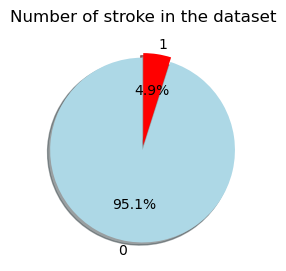

In [7]:
labels =raw_data['stroke'].value_counts(sort = True).index
sizes = raw_data['stroke'].value_counts(sort = True)

colors = ["lightblue","red"]
explode = (0.05,0) 
 
plt.figure(figsize=(3,3))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Number of stroke in the dataset')
plt.show()

In [8]:
def plot_hist(col, bins=30, title="",xlabel="",ax=None):
    sns.distplot(col, bins=bins,ax=ax)
    ax.set_title(f'Histogram of {title}',fontsize=20)
    ax.set_xlabel(xlabel)

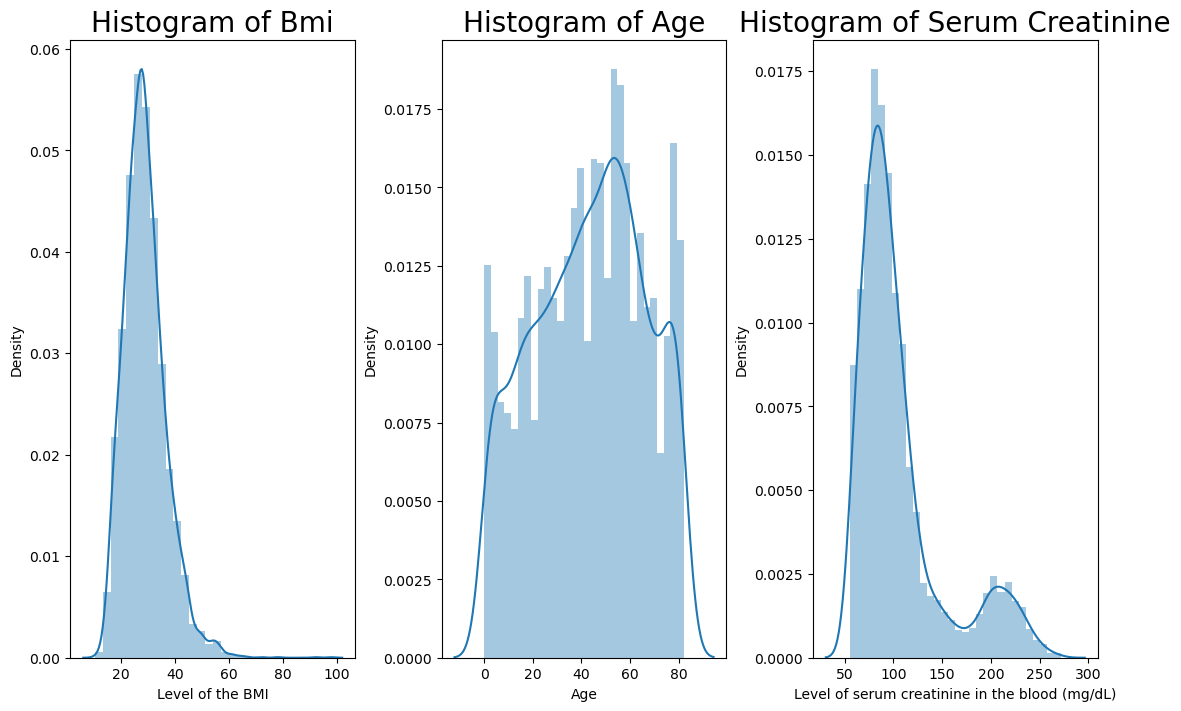

In [9]:
fig, axes = plt.subplots(1,3,figsize=(11,7),constrained_layout=True)
plot_hist(raw_data.bmi,title='Bmi',xlabel="Level of the BMI",ax=axes[0])

plot_hist(raw_data.age,bins=30,title='Age',xlabel='Age',ax=axes[1])

plot_hist(raw_data.avg_glucose_level,title='Serum Creatinine', xlabel='Level of serum creatinine in the blood (mg/dL)', ax=axes[2])

plt.show()


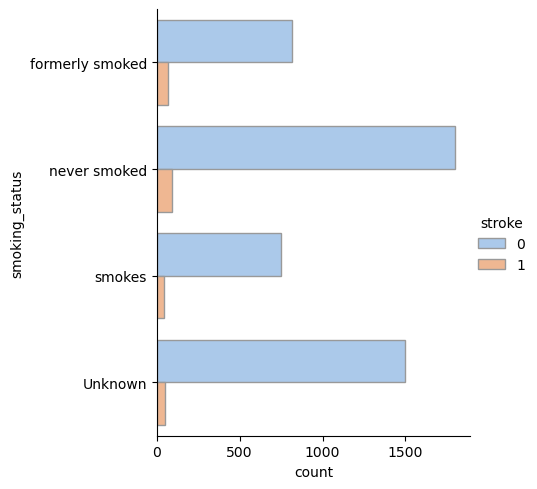

In [10]:
sns.catplot(y="smoking_status", hue="stroke", kind="count",
            palette="pastel", edgecolor=".6",
            data=raw_data)

seems that the stroke is **`not highly`** corralated to smokers since the proportion of person having a stroke is fairly the same among the other smoking status.

### Predictive Power Score (PPS)

Text(50.58159722222221, 0.5, 'target')

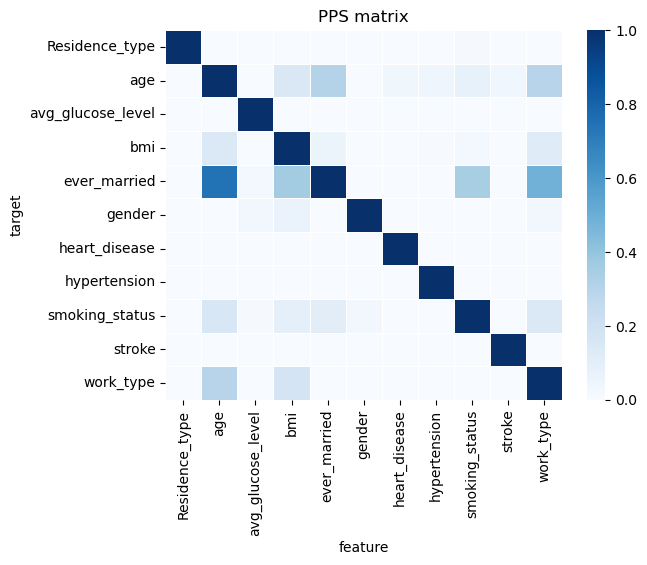

In [11]:
mat = pps.matrix(raw_data)
mat = mat[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
ax = sns.heatmap(mat, vmin=0, vmax=1, cmap="Blues", linewidths=0.5)
ax.set_title("PPS matrix")
ax.set_xlabel("feature")
ax.set_ylabel("target")

<Figure size 200x200 with 0 Axes>

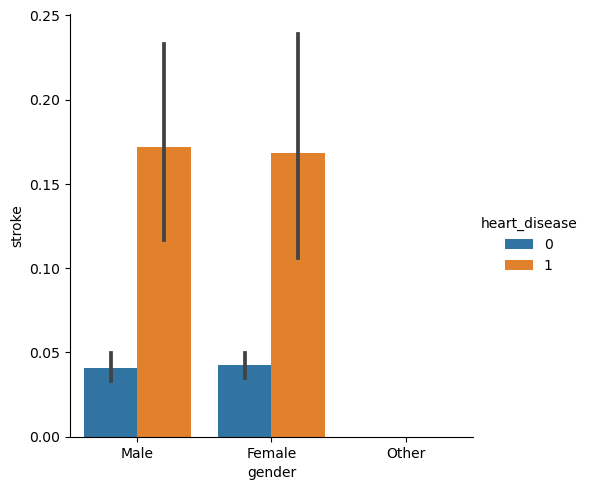

In [12]:
plt.figure(figsize=(2,2))
sns.catplot(x="gender", y="stroke", hue="heart_disease", kind="bar", data=raw_data)

in terms of gender it's not truly spreatable

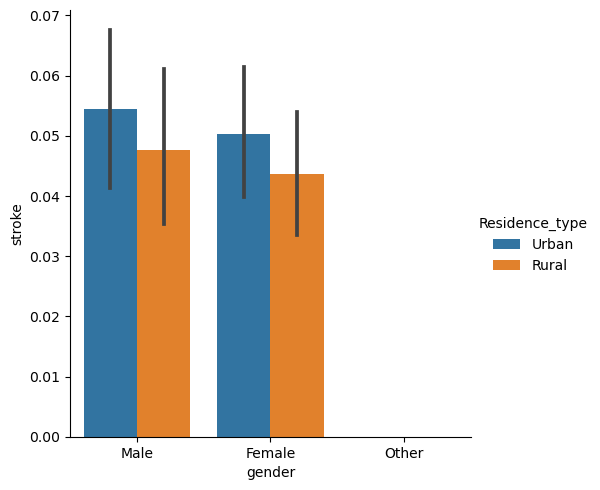

In [13]:
sns.catplot(x="gender", y="stroke", hue="Residence_type", kind="bar", data=raw_data)

sounds like Males in Urban are just a bit more likly to have strok than others

In [14]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [15]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


*`hypertension`* : it's already between 0 and 1, doesn't need scalling<br>
*`heart_disease`* : it's a binary value: 0-> don't have, 1-> have<br>
*`strok`* : also binary vlaues
*`avg_glucose_level`* : need scalling !<br>
*`bmi`* : need too<br>
*`age`* : i'd like to binning it, i will try it

### `Splitting` the data

In [16]:
features = raw_data.loc[:,:'smoking_status']
target = raw_data.loc[:,'stroke']

In [17]:
X = features
y = target
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))

X.shape: (5110, 10)  y.shape: (5110,)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [19]:
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=0.2)

In [20]:
# X_val.shape

### Feature preprocessing and pipline:<br>

In [21]:
num_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status' ]

In [22]:
cat_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy= 'most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown= 'ignore', sparse= False)),
    ]
)

num_transformer = Pipeline(
    steps = [
        ('imputer', KNNImputer(n_neighbors= 5)),
        ('sclaer', StandardScaler() ),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [23]:
def train_model(classifier, resample=False):
    
    if resample:
        clf = impipeline(steps=[('preprocessor', preprocessor ),
                ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
                ('classifier', classifier)])

    else: 
        clf = Pipeline(steps=[('preprocessor', preprocessor ),
                      ('classifier', classifier)])
        
    model = clf.fit(X_train, y_train)
    return model

In [24]:
def R2_model(model, y_true, y_predicted):
    print("R-squared scores are:\n")
    print("r2_score (linear model): {:.2f}".format(r2_score(y_true, y_predicted)))
    
    # print('score (training): {:.3f}'
    #  .format(model.score(x1, y1)))
    # print('score (test): {:.3f}'
    #     .format(model.score(x2, y2)))

In [25]:
lrr = train_model(LogisticRegression(),False)

In [26]:
y_predictedd = lrr.predict(X_test)

In [27]:
print(classification_report(y_test, y_predictedd, target_names = ['0 class', '1 class']))

              precision    recall  f1-score   support

     0 class       0.95      1.00      0.97       972
     1 class       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



In [28]:
# Step 1: Define models and their hyperparameters
models = {
    "logistic_regression": {
    "estimator": LogisticRegression(),
    "param_grid": {
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": [0.1, 1, 10],
        "classifier__solver": ["liblinear", "lbfgs"]
    }
},
    "random_forest": {
        "estimator": RandomForestClassifier(),
        "param_grid": {
            "classifier__n_estimators": [10, 50, 100],
            "classifier__max_depth": [3, 5, None],
            "classifier__min_samples_split": [2, 5]
        }
    },
    "decision_tree": {
    "estimator": DecisionTreeClassifier(),
    "param_grid": {
        "classifier__max_depth": [3, 5, None],
        "classifier__min_samples_split": [2, 5],
        "classifier__min_samples_leaf": [1, 2]
    }
},
    "gradient_boosted_trees": {
    "estimator": GradientBoostingClassifier(),
    "param_grid": {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__learning_rate": [0.01, 0.1, 1],
        "classifier__max_depth": [3, 5, None],
        "classifier__min_samples_split": [2, 5],
        "classifier__min_samples_leaf": [1, 2]
    }
}
}

In [29]:
# Step 2: Use GridSearchCV for hyperparameter tuning
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1_score": "f1",
    "auc": "roc_auc"
}

In [30]:
# from sklearn.datasets import make_classification

In [31]:
cv = 5  # number of cross-validation folds
# Step 3: Cross-validation
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessing_step_v0 = preprocessor


In [32]:
# Step 4: Track all the models using MLflow
for model_name, model_params in models.items():
    with mlflow.start_run(run_name=model_name) as run:
        mlflow.log_param("model", model_name)
        mlflow.log_param("preprocessing", "preprocessing_step_v0")
        
        # Define the pipeline with the preprocessing steps and classifier
        pipeline = impipeline([
            # edite the preprocessing
            ('preprocessing', preprocessing_step_v0),
            ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
            ('classifier', model_params["estimator"])
        ])
        
        # Define the hyperparameter grid to search over
        param_grid = model_params["param_grid"]
        
        # Define the grid search object
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit="auc", n_jobs=-1)
        
        # Fit the grid search object to the data
        grid_search.fit(X_train, y_train)
        
        # Get the best estimator from the grid search
        best_estimator = grid_search.best_estimator_

        # Step 5: Use a couple of matrices such as AUC, accuracy, precision, recall, F1, F2
        y_pred_train = best_estimator.predict(X_train)
        y_proba_train = best_estimator.predict_proba(X_train)[:, 1] # Probability of positive class
        accuracy_train = accuracy_score(y_train, y_pred_train)
        precision_train = precision_score(y_train, y_pred_train)
        recall_train = recall_score(y_train, y_pred_train)
        f1_train = f1_score(y_train, y_pred_train)
        auc_train = roc_auc_score(y_train, y_proba_train)
        f2_train = make_scorer(fbeta_score, beta=2)(best_estimator, X_train, y_train)


        y_pred_test = best_estimator.predict(X_test)
        y_proba_test = best_estimator.predict_proba(X_test)[:, 1] # Probability of positive class
        accuracy_test = accuracy_score(y_test, y_pred_test)
        precision_test = precision_score(y_test, y_pred_test)
        recall_test = recall_score(y_test, y_pred_test)
        f1_test = f1_score(y_test, y_pred_test)
        auc_test = roc_auc_score(y_test, y_proba_test)
        f2_test = make_scorer(fbeta_score, beta=2)(best_estimator, X_test, y_test)
        
        
        # Step 6: Plot all matrices
        mlflow.log_metric("accuracy_train", accuracy_train)
        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("f1_score_train", f1_train)
        mlflow.log_metric("auc_train", auc_train)
        mlflow.log_metric("f2_score_train", f2_train)
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("f1_score_test", f1_test)
        mlflow.log_metric("auc_test", auc_test)
        mlflow.log_metric("f2_score_test", f2_test)
        
        
        # Log the best hyperparameters
        mlflow.log_params(grid_search.best_params_)

AttributeError: predict_proba is not available when  probability=False